# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

### Preprocessing
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp 
###

import seaborn as sns

# Fetching and Processing Data

In [2]:
# Load Features
features_filepath = 'data/UCI HAR Dataset/features.txt'
with open(features_filepath) as features_file:
    feature_names = [line.split()[1] for line in features_file.readlines()]

# Load Training Data
train_data_filepath = 'data/UCI HAR Dataset/train/'
X_train_filepath = f'{train_data_filepath}X_train.txt'
y_train_filepath = f'{train_data_filepath}y_train.txt'

X_train = pd.read_csv(X_train_filepath, delim_whitespace=True, header=None)
X_train.columns = feature_names

y_train = pd.read_csv(y_train_filepath, names=['Activity']).iloc[:, 0]

# Load Testing Data
test_data_filepath = 'data/UCI HAR Dataset/test/'
X_test_filepath = f'{test_data_filepath}X_test.txt'
y_test_filepath = f'{test_data_filepath}y_test.txt'

X_test = pd.read_csv(X_test_filepath, delim_whitespace=True, header=None)
X_test.columns = feature_names

y_test = pd.read_csv(y_test_filepath, names=['Activity']).iloc[:, 0]

### For Singular Modality Analysis Comparision ###
selected_columns = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']
X_train_subset = X_train[selected_columns]
X_test_subset = X_test[selected_columns]


# PCA

In [3]:
##Convert To Numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

#Subset of data
X_train_subset = X_train_subset.to_numpy()
X_test_subset = X_test_subset.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# create an instance of the StandardScaler() object
mean_datascaler_1 = sklpp.StandardScaler(with_mean=True, with_std=False)
skl_centered_X_1 = mean_datascaler_1.fit_transform(X_train) # use the fit_transform API to simultaneously compute mean and center data
u1 = mean_datascaler_1.mean_.reshape((1, -1)) #Empirical Mean Vector

# create another instance of the StandardScaler() object
mean_datascaler_2 = sklpp.StandardScaler(with_mean = True, with_std = False)
skl_centered_X_subset = mean_datascaler_2.fit_transform(X_train_subset)
u2 = mean_datascaler_2.mean_.reshape((1, -1)) #Empirical Mean Vector

#Center Data
X_train_centered = X_train - u1
X_train_subset_centered = X_train_subset - u2

# create an instance of the PCA() object
data_pca1 = skldecomp.PCA(n_components = 0.99, svd_solver= 'full')
data_pca2 = skldecomp.PCA(n_components = 0.99, svd_solver= 'full')

# use fit_transform API to simultaneously compute PCA features & directions
skl_features_training = data_pca1.fit_transform(X_train_centered)
sk2_features_training = data_pca2.fit_transform(X_train_subset_centered)

#Center Test Data 
X_test_centered = X_test - u1
X_test_subset_centered = X_test_subset - u2

#### Set up X_train and X_test
X_train = skl_features_training
X_train_subset = sk2_features_training

X_test = data_pca1.transform(X_test_centered)
X_test_subset = data_pca2.transform(X_test_subset_centered)

# Set Up Grid Search And LR Model

In [4]:
# Define hyperparameters grid
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30], 'penalty': ['l2', 'l1']}

# Create a Logistic Regression model
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_singular_model = linear_model.LogisticRegression()

# Set up GridSearchCV
log_reg_grid_search = GridSearchCV(logistic_regression_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
log_reg_sig_grid_search = GridSearchCV(logistic_regression_singular_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Train LR Model

In [5]:
# Dictionary to store results
results_dict = {}

# Ignore warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Record the start time for training
training_start_time = datetime.now()
print('Model Training has Started!')

# Fit the logistic regression model
logistic_regression_model.fit(X_train, y_train)
logistic_regression_singular_model.fit(X_train_subset, y_train)

# Print a message indicating the end of training
print('Model Training Done!\n')

# Record the end time for training
training_end_time = datetime.now()

# Calculate and store the training time
results_dict['training_time'] = training_end_time - training_start_time
print('Training Time: {}\n'.format(results_dict['training_time']))

Model Training has Started!
Model Training Done!

Training Time: 0:00:00.520383



# Predicting Test Data

In [6]:
# Print a message indicating the start of the prediction on test data
print('Predicting Test data')

# Record the start time for testing
testing_start_time = datetime.now()

# Predict on the test data
y_pred = logistic_regression_model.predict(X_test)
y_pred_sig = logistic_regression_singular_model.predict(X_test_subset)


# Record the end time for testing
testing_end_time = datetime.now()
print('Predictions Done!\n')

# Calculate and store the testing time
results_dict['testing_time'] = testing_end_time - testing_start_time
print('Testing Time: {}\n'.format(results_dict['testing_time']))

# Store the predicted values
results_dict['predicted'] = y_pred

Predicting Test data
Predictions Done!

Testing Time: 0:00:00.002230



# Calculated Accuracy

In [7]:
# Calculate accuracy
accuracy_score = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
accuracy_score_singular = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_sig)

# Store accuracy in the results dictionary
results_dict['accuracy'] = accuracy_score

# Print the singular modality accuracy
print('Singular Modality Model Accuracy: {}\n'.format(accuracy_score_singular))

# Print the multimodal accuracy
print('Multimodal Model Accuracy: {}\n'.format(accuracy_score))

Singular Modality Model Accuracy: 0.20631150322361724

Multimodal Model Accuracy: 0.9562266711910418



# Calculating Confusion Matrix

In [8]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [9]:
# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix_singular = metrics.confusion_matrix(y_test, y_pred_sig)

# Store confusion matrix in the results dictionary
results_dict['confusion_matrix'] = confusion_matrix

# Print the singular Modality Model confusion matrix
print('\nSingular Modality Model Confusion Matrix:')
print('\n{}'.format(confusion_matrix_singular))

print('\n\n')
# Print the singular Modality Model confusion matrix
print('\nMultiModal Model Confusion Matrix:')
print('\n{}'.format(confusion_matrix))


Singular Modality Model Confusion Matrix:

[[  0  11   0   6 205 274]
 [  0  66   0  12 154 239]
 [  0  22  10  10 190 188]
 [  0   4   0  19  32 436]
 [  0   9   2   9  91 421]
 [  0   5   2   0 108 422]]




MultiModal Model Confusion Matrix:

[[493   0   3   0   0   0]
 [ 27 442   2   0   0   0]
 [  4  13 403   0   0   0]
 [  0   3   0 429  59   0]
 [  1   0   0  17 514   0]
 [  0   0   0   0   0 537]]


# Plot Confusion Matrix

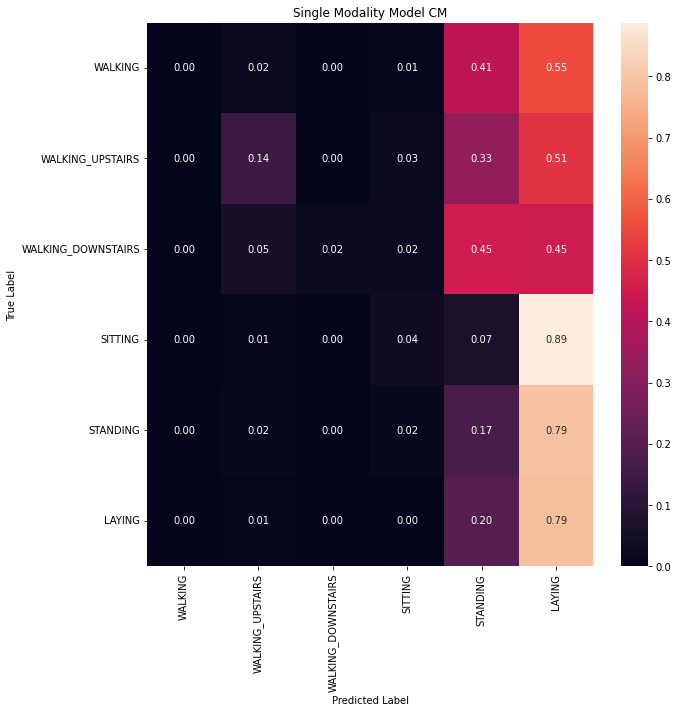

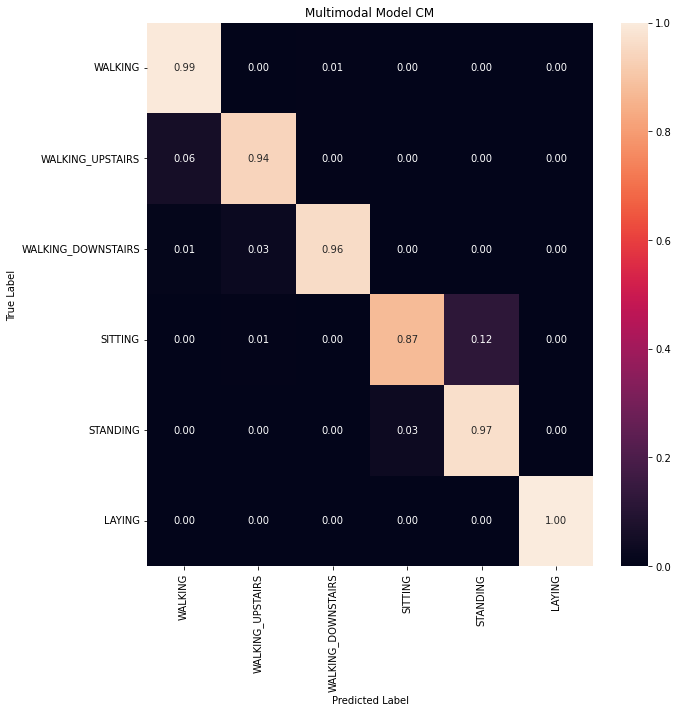

In [10]:
#Plot Normalized Confusion for Singular Modality Model Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix_singular.astype('float') / confusion_matrix_singular.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.title('Single Modality Model CM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)


#Plot Normalized Confusion for Multimodal Model Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.title('Multimodal Model CM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

# Classification Report

In [11]:
# Get classification report
print('Classification Report of Singular Modality Model')
classification_report_result = metrics.classification_report(y_test, y_pred_sig)

# Print the classification report
print(classification_report_result)

# Get classification report
print('\nClassification Report of Multimodal Model')
classification_report_result = metrics.classification_report(y_test, y_pred)

# Print the classification report
print(classification_report_result)

Classification Report of Singular Modality Model
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.56      0.14      0.22       471
           3       0.71      0.02      0.05       420
           4       0.34      0.04      0.07       491
           5       0.12      0.17      0.14       532
           6       0.21      0.79      0.34       537

    accuracy                           0.21      2947
   macro avg       0.32      0.19      0.14      2947
weighted avg       0.31      0.21      0.14      2947


Classification Report of Multimodal Model
              precision    recall  f1-score   support

           1       0.94      0.99      0.97       496
           2       0.97      0.94      0.95       471
           3       0.99      0.96      0.97       420
           4       0.96      0.87      0.92       491
           5       0.90      0.97      0.93       532
           6       1.00      1.00      1